# Operability Mapping of Solid Oxide Electrolyzer Cell systems Using the IDAES and Opyrability Toolkit

Author: Krishna Murthy Busam, West Virginia University PhD Student

This notebook demonstrates how to connect a Solid Oxide Electrolyzer Cell (SOEC) simulation model built with the IDAES platform to Python for operability analysis using the opyrability library. The approach focuses on visualizing the impact of varying current density and temperature on the SOEC voltage, which is crucial for optimizing stack performance and evaluating system flexibility.

This method serves as a general template for connecting Python-based process models with operability analysis tools. It can be extended to surrogate models, real-time simulations, or hybrid modeling workflows.

# Overview of the SOEC Model


![](H_SOEC.png)
Figure : Schematic of the operational principles governing SOEC.

The IDAES-based SOEC model represents a simplified electrochemical block focused on design-point evaluation. It computes cell voltage based on user-specified values of: 
**1.Current Density [A/cm²]**  
**2.Operating Temperature [K]**

Operability study includes 2 cases which are stated below in the table. The electrochemical model includes reversible, activation and ohmic overpotentials and returns a computed cell voltage. This helps assess performance across a design space and guides the sizing and efficiency strategies of the SOEC system.

**Case 1**: $\mathbb{R}^2 \rightarrow \mathbb{R}^1$(Input $\rightarrow$ Output) system

| Input (Available Input Set)                | Output (Achievable Output Set)                 |
|---------------------------|------------------------------|
| Current Density (J) [A/cm²]       | Cell Voltage [V]          |
|   Temperature (T) [K]     | - |


**Case 2**: $\mathbb{R}^2 \rightarrow \mathbb{R}^2$ (Input $\rightarrow$ Output) system

| Input (Available Input Set)                | Output (Achievable Output Set)                 |
|---------------------------|------------------------------|
| Current Density (J) [A/cm²]       | Cell Voltage [V]          |
|   Temperature (T) [K]     | Hydrogen Production [gm/sec] |

# Software and Library Requirements

The following tools and libraries are required to execute the operability analysis of the SOEC model using the IDAES platform and the `opyrability` framework:

- **Python** version 3.8 or higher
- **IDAES Framework** ([idaes.org](https://idaes.org/))
- **opyrability** library for operability analysis ([Opyrability package](https://codes-group.github.io/opyrability/intro.html))
- **IPOPT** solver for nonlinear optimization ([IPOPT](https://coin-or.github.io/Ipopt/))
- Python packages:
  - `numpy` – numerical operations
  - `matplotlib` – visualization
  - `pyomo` – algebraic modeling language

# Step-by-Step Integration

# Case1: Forward Mapping
$\mathbb{R}^2 \rightarrow \mathbb{R}^1$ (Input $\rightarrow$ Output) system

**1. Model Setup**

The SOEC model is defined using Pyomo and IDAES to create a voltage calculation block based on electrochemical principles.



In [13]:
from pyomo.environ import ConcreteModel, Var, Expression, Constraint, SolverFactory, value, exp, asinh
from idaes.core import FlowsheetBlock
import numpy as np
import matplotlib.pyplot as plt
from opyrability import AIS2AOS_map

**2. Build the IDAES SOEC Model**

The model calculates cell voltage as a function of temperature and current density using expressions for reversible potential, activation overpotential, and ohmic loss.

In [14]:
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)
# Variables
m.fs.J = Var(initialize=0.5, bounds=(0.0001, 1.2))  # A/cm^2
m.fs.T = Var(initialize=1000, bounds=(923, 1173))   # K
m.fs.V = Var(initialize=1.3)  # V

# Constants and expressions

In [15]:
# Constants
R = 8.314 # J/(mol·K)
F = 96485.33212331059 # C/mol
gam_a = 1.651e5 # A/cm^2
gam_c = 2.344e6 # A/cm^2
E_act_a = 1.2e5 # J/mol
E_act_c = 1.2e5 # J/mol
L = 400e-4 #m

# --------Electrochemical Equations--------#

# Open circuit voltage equation
m.fs.E0 = Expression(expr=1.2535 - 0.00024516 * m.fs.T)

#Activation overpotential equations
m.fs.J0_a = Expression(expr=gam_a * exp(-E_act_a / (R * m.fs.T)))
m.fs.J0_c = Expression(expr=gam_c * exp(-E_act_c / (R * m.fs.T)))
m.fs.eta_act_a = Expression(expr=(R * m.fs.T / F) * asinh(m.fs.J / (2 * m.fs.J0_a)))
m.fs.eta_act_c = Expression(expr=(R * m.fs.T / F) * asinh(m.fs.J / (2 * m.fs.J0_c)))

# Ohmic overpotential equations
m.fs.phi = Expression(expr=70.9e-6 * exp(10300 / m.fs.T))
m.fs.eta_ohmic = Expression(expr=m.fs.J * L * m.fs.phi)

# Voltage equation
m.fs.voltage_eqn = Constraint(expr=m.fs.V == m.fs.E0 + m.fs.eta_act_a + m.fs.eta_act_c + m.fs.eta_ohmic)

Solve the model using IPOPT or any other optimization solver

In [16]:
# Solver
solver = SolverFactory('ipopt')

# 3. Define the Model for Operability Analysis

In [17]:
# Input-output mapping
def SOEC_IDAES(u):
    m.fs.J.fix(u[0])
    m.fs.T.fix(u[1])
    solver.solve(m, tee=False)
    return np.array([value(m.fs.V)])

# 4. Define Input Space for Operability Analysis

In [18]:
AIS_bounds = np.array([[0.0001, 1.2], [923.0, 1173.0]])  # [current density, temperature]
resolution = [20, 20]

# 5. Perform Mapping from AIS to AOS and Plot according to shape
## Matplotlib widget
+ Installation: pip install ipympl

+ In your Jupyter Notebook, activate the interactive widget backend by using: %matplotlib widget

+ You'll now be able to: Zoom in/out, Pan around, Resize the plot dynamically, and Hover to see coordinates


preallocation completed


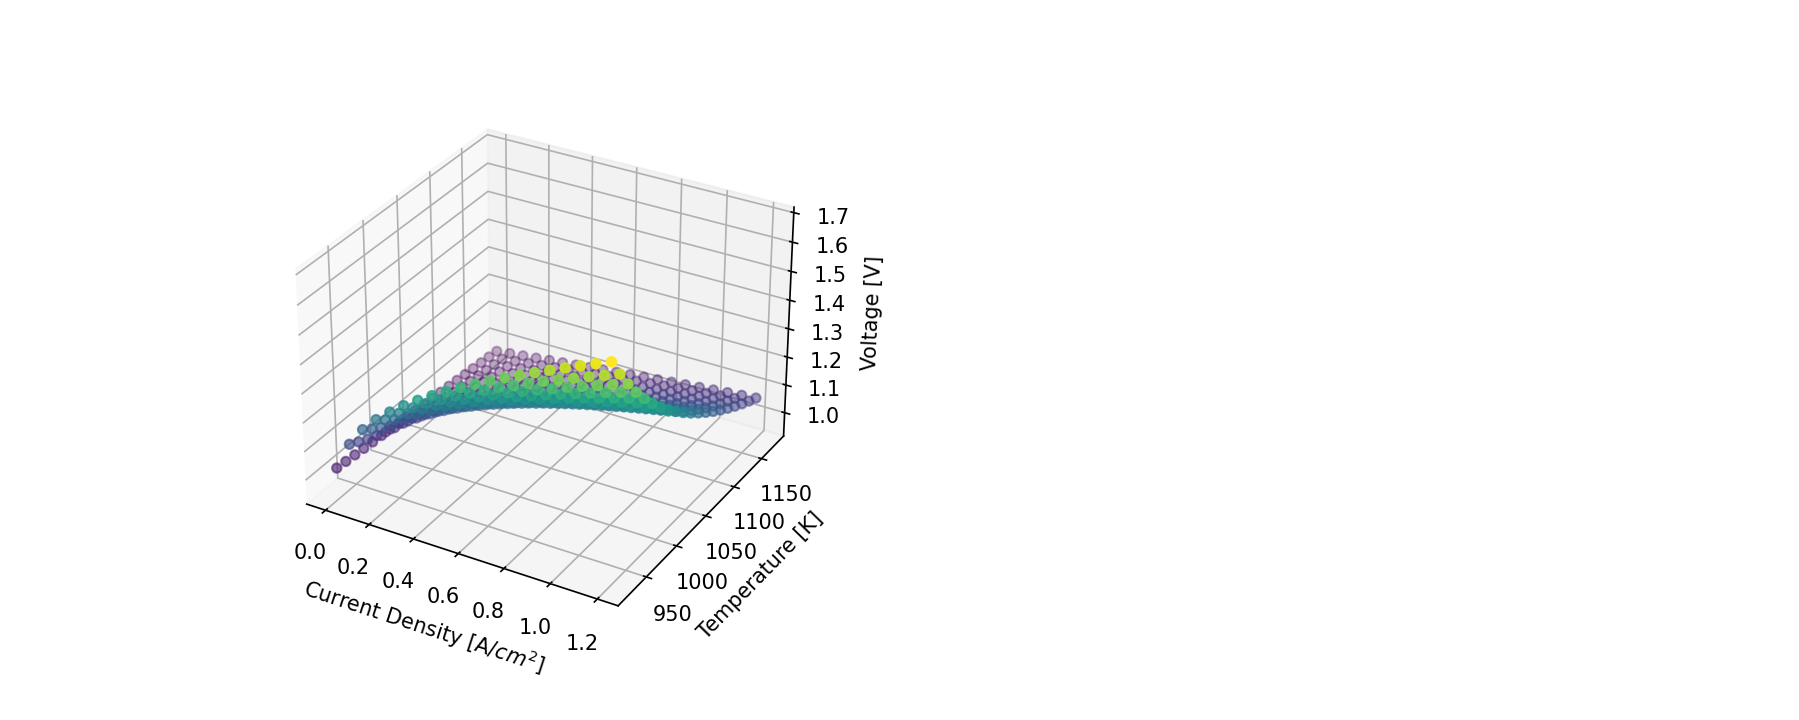

In [19]:
AIS, AOS =  AIS2AOS_map(SOEC_IDAES, AIS_bounds,  resolution, plot = False)
# Plotting
AIS_new = AIS.reshape(resolution[0]*resolution[1],-1)
AOS_new = AOS.reshape(resolution[0]*resolution[1],-1)
%matplotlib widget
import matplotlib.pyplot as plt
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1,2,1, projection='3d')

ax.set_ylabel('Temperature [K]')
ax.set_xlabel('Current Density [A/$cm^2$]')
ax.set_zlabel('Voltage [V]')

ax.scatter(AIS_new[:,0], AIS_new[:, 1], AOS_new, c =np.sqrt(AOS_new[:, 0]**2),
                        cmap='viridis', antialiased=True,
                        lw=1, marker='o')

# Case 2 : Forward Mapping

$\mathbb{R}^2 \rightarrow \mathbb{R}^2$ (Input $\rightarrow$ Output) system

| Input (Available Input Set)                | Output (Achievable Output Set)                 |
|---------------------------|------------------------------|
| Current Density (J) [A/cm²]       | Cell Voltage [V]          |
|   Temperature (T) [K]     | Hydrogen Production [gm/sec]|

In [20]:
from pyomo.environ import ConcreteModel, Var, Expression, Constraint, SolverFactory, value, exp, asinh
from idaes.core import FlowsheetBlock
import numpy as np
import matplotlib.pyplot as plt
from opyrability import AIS2AOS_map

# --- 1. Model setup ---
m = ConcreteModel()
m.fs = FlowsheetBlock(dynamic=False)

# Inputs
m.fs.J = Var(initialize=0.5, bounds=(0.0001, 1.2), doc="Current density [A/cm^2]")
m.fs.T = Var(initialize=1000, bounds=(923, 1173), doc="Temperature [K]")

# Outputs
m.fs.V = Var(initialize=1.3, doc="Voltage [V]")

# Constants
R = 8.314  # J/mol-K
F = 96485.33212331059  # C/mol
gam_a = 1.651e5 # A/cm^2
gam_c = 2.344e6 # A/cm^2
E_act_a = 1.2e5 # J/mol
E_act_c = 1.2e5 #J/mol
L = 400e-4  # m
A_cell = 5.0  # cm^2

# --- Electrochemical equations ---
m.fs.J0_a = Expression(expr=gam_a * exp(-E_act_a / (R * m.fs.T)))
m.fs.J0_c = Expression(expr=gam_c * exp(-E_act_c / (R * m.fs.T)))
m.fs.E0 = Expression(expr=1.2535 - 0.00024516 * m.fs.T)
m.fs.eta_act_a = Expression(expr=(R * m.fs.T / F) * asinh(m.fs.J / (2 * m.fs.J0_a)))
m.fs.eta_act_c = Expression(expr=(R * m.fs.T / F) * asinh(m.fs.J / (2 * m.fs.J0_c)))
m.fs.phi = Expression(expr=70.9e-6 * exp(10300 / m.fs.T))
m.fs.eta_ohmic = Expression(expr=m.fs.J * L * m.fs.phi)

# Total voltage equation
m.fs.voltage_eqn = Constraint(expr=m.fs.V == m.fs.E0 + m.fs.eta_act_a + m.fs.eta_act_c + m.fs.eta_ohmic)

# Hydrogen production rate [Nm^3/hr]
# mol/s = (J [A/cm^2] * Area [cm^2]) / (2 * F)
# Nm3/hr = mol/s * 22.4 (L/mol) / 1000 * 3600
m.fs.H2_prod = Expression(expr=(m.fs.J * A_cell) / (2 * F) * 22.4 / 1000 * 3600)

# --- Solver ---
solver = SolverFactory('ipopt')

# --- Input-output mapping function ---
def SOEC_IDAES_2out(u):
    m.fs.J.fix(u[0])
    m.fs.T.fix(u[1])
    solver.solve(m, tee=False)
    return np.array([value(m.fs.V), value(m.fs.H2_prod)])  # V, H2 rate


### Setup Desired Output Set Bounds

In [ ]:
from opyrability import AIS2AOS_map

#AIS Current Density (J) and Temperature (K)
AIS_bounds =  np.array([[0.0001, 1.2],
                        [923.0, 1073.0]])

AIS_resolution =  [10, 10]
 
model =  SOEC_IDAES_2out


preallocation completed


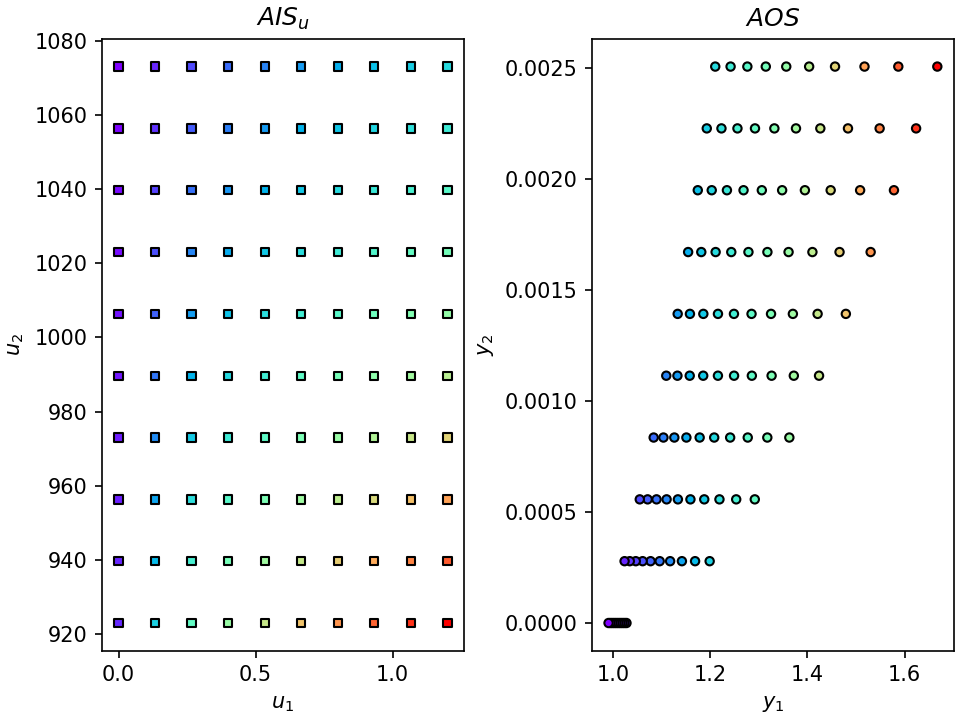

In [22]:
AIS, AOS =  AIS2AOS_map(SOEC_IDAES_2out, AIS_bounds,  AIS_resolution, plot = True)

Additionally, we can create a visualization of the Achievable Output Space (AOS) by using the `multimodel_rep` function from opyrability, which takes about the same amount of time as the `AIS2AOS_map`.


preallocation completed


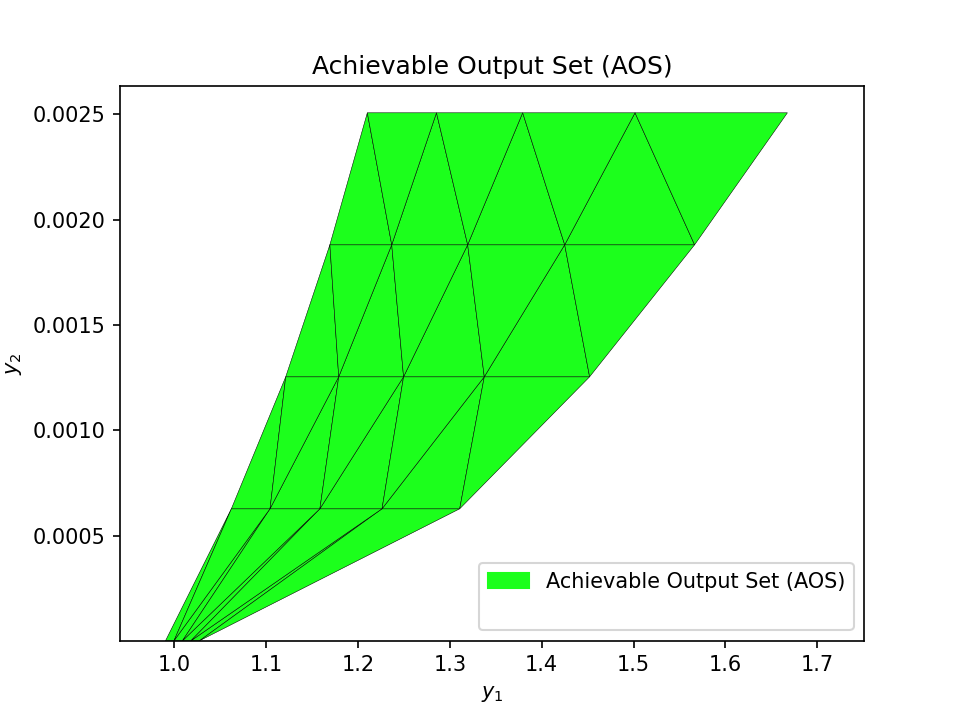

In [23]:
from opyrability import multimodel_rep
resolution = [5,5]
AOS_region  =  multimodel_rep(SOEC_IDAES_2out, AIS_bounds, resolution)

## Desired Output Set and Operability Index Evaluation for SOEC-Based Hydrogen Production

Now that the Achievable Output Space (AOS) has been established for the SOEC process, we can define various Desired Output Set (DOS) to reflect target operating regions based on system-level performance goals. The **Operability Index (OI)** is then used to quantify how much of each DOS is actually achievable by the process, given the Available Input Set (AIS). The OI is defined as the fraction of the DOS that overlaps with the AOS.

For this SOEC case study, the two outputs of interest are:

- **Cell Voltage [V]**
- **Hydrogen Production Rate [g/s]**

We define two scenarios for the DOS, representing hydrogen production targets within an acceptable voltage range. These ranges reflect practical operating targets for high-efficiency hydrogen production while maintaining cell voltage within a realistic range for stable SOEC operation.

### Desired Output Set (DOS)

| Case  | Voltage Range (V) | Hydrogen Production Rate (g/s) |
|-------|-------------------|---------------------------------|
| DOS 1 | 1.1 – 1.5         | 0.0001 – 0.0005                 |
| DOS 2 | 1.1 – 1.5         | 0.0015 – 0.0020                 |

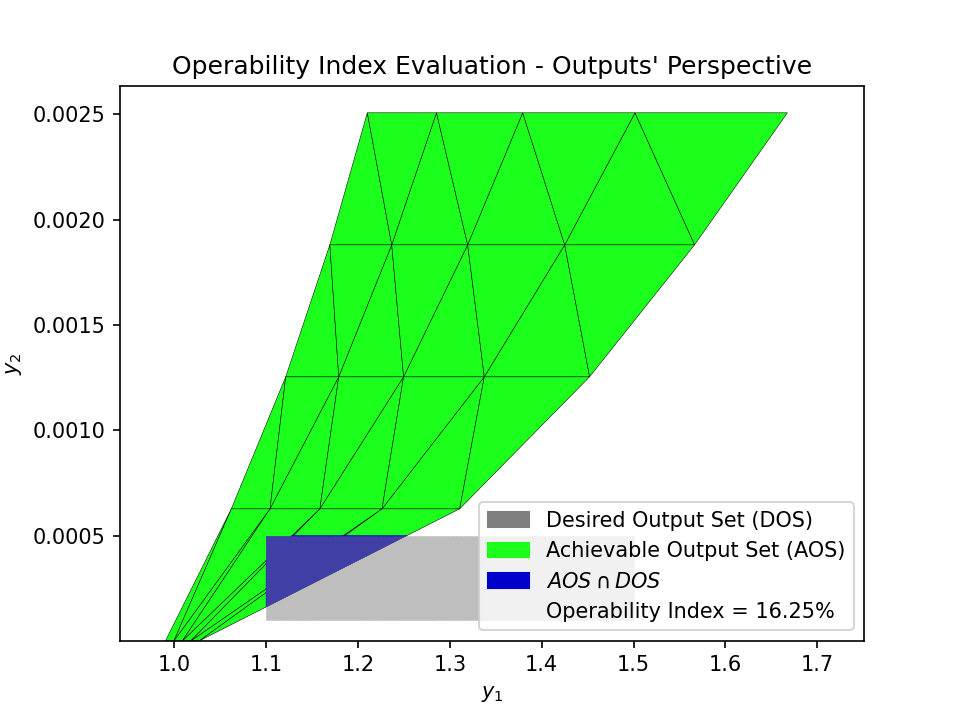

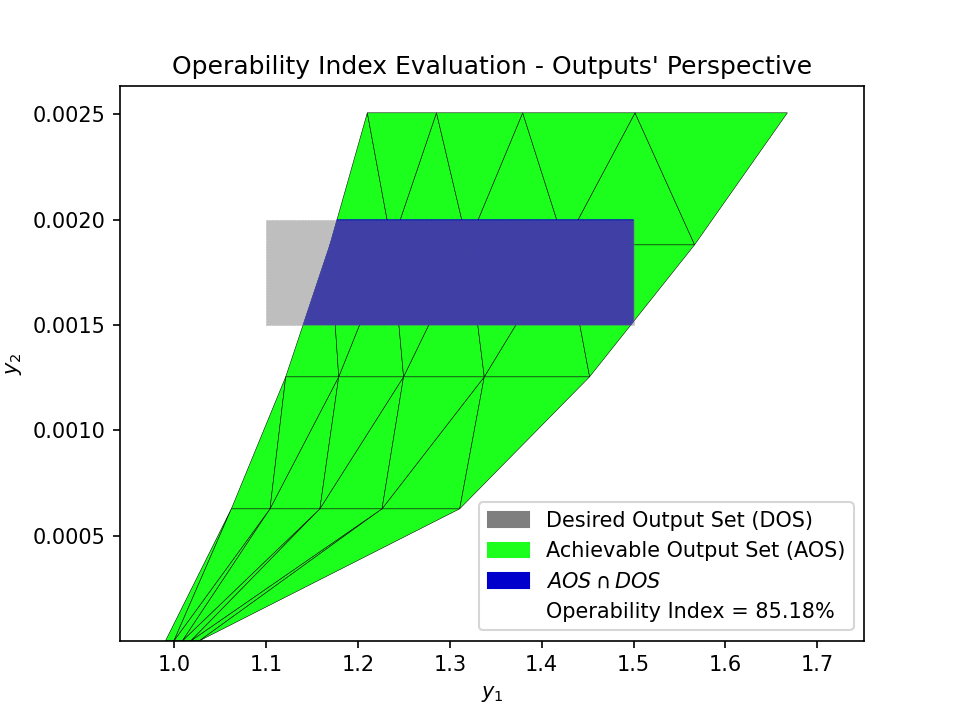

In [24]:
from opyrability import OI_eval
DOS_bounds_1 =  np.array([[1.1, 1.5], 
                        [0.0001, 0.0005]])
 
DOS_bounds_2 =  np.array([[1.1, 1.5], 
                        [0.0015, 0.002]])

OI = OI_eval(AOS_region, DOS_bounds_1)

OI = OI_eval(AOS_region, DOS_bounds_2)


These DOS scenarios can be used to evaluate how the operability of the SOEC system changes with tighter hydrogen production targets. A higher OI indicates that a greater portion of the desired operating region is achievable by the system, while a lower OI may suggest the need for design modifications, advanced control strategies, or broader input flexibility.

Desired Output Set (DOS) and their OI calculation


| Case  | Voltage Range (V) | Hydrogen Production Rate (g/s) | OI (%)
|-------|-------------------|---------------------------------|-------|
| DOS 1 | 1.1 – 1.5         | 0.0001 – 0.0005                 | 16.25  |
| DOS 2 | 1.1 – 1.5         | 0.0015 – 0.0020                 | 85.18 |

Interpretation

- **DOS 1** shows a low operability index (16.25%), indicating that only a small part of this low H₂ production range can be reached with the current SOEC setup.
- **DOS 2** is the most favorable target region, with an OI of 85.18%, meaning the system is well-suited to operate within this output range.